In [2]:
import pandas as pd
import pyarrow.dataset as pads
import os

In [3]:
data_path = "/Users/pranavrajaram/SMT-Data-Challenge-2025"

In [4]:
def readDataSubset(table_type, data_path):
    """
    Loads a specified SMT data subset as a PyArrow dataset.
    """
    valid_tables = ['ball_pos', 'game_events', 'game_info', 'player_pos', 'rosters']
    if table_type not in valid_tables:
        print("Invalid data subset name. Please try again with a valid data subset.")
        return None

    if table_type == 'rosters':
        return pads.dataset(source=os.path.join(data_path, 'rosters.csv'), format='csv')
    else:
        
        return pads.dataset(
            source=os.path.join(data_path, table_type),
            format='csv'
        )

In [5]:
game_info_ds = readDataSubset('game_info', data_path)
game_events_ds = readDataSubset('game_events', data_path)
ball_pos_ds = readDataSubset('ball_pos', data_path)
player_pos_ds = readDataSubset('player_pos', data_path)
rosters_ds = readDataSubset('rosters', data_path)

In [6]:
import pyarrow as pa

filter_criteria = (
    (pads.field("home_team") == "QEA")
)

game_info_df = game_info_ds.to_table().to_pandas()
game_events_df = game_events_ds.to_table().to_pandas()

In [7]:
# some keys
position_key = pd.DataFrame({
    "code": [*range(1, 14), 255, 14, 15, 16, 17, 18, 19],
    "position": [
        "pitcher", "catcher", "first baseman", "second baseman", "third baseman",
        "shortstop", "left field", "center field", "right field", "batter",
        "runner on first base", "runner on second base", "runner on third base",
        "ball event with no player (e.g., ball bounce)", "home plate umpire",
        "field umpire", "field umpire", "field umpire",
        "first base coach", "third base coach"
    ]
})

event_key = pd.DataFrame({
    "code": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16],
    "play_type": [
        "pitch", "ball acquired", "throw (ball-in-play)", "ball hit into play", 
        "end of play", "pickoff throw", "ball acquired - unknown field position", 
        "throw (ball-in-play) - unknown field position", "ball deflection", 
        "ball deflection off of wall", "home run", "ball bounce"
    ]
})

In [8]:
big_ie = pd.merge(
    game_events_df, 
    game_info_df, 
    on=['game_str', 'play_per_game'], 
    suffixes=('', '_dup')
)

big_ie = big_ie.loc[:, ~big_ie.columns.str.endswith('_dup')]

big_ie['player_position'] = pd.to_numeric(big_ie['player_position'], errors='coerce').astype('Int64')
big_ie['event_code'] = pd.to_numeric(big_ie['event_code'], errors='coerce').astype('Int64')

big_ie = big_ie.merge(position_key, how='left', left_on='player_position', right_on='code').drop('code', axis=1)

big_ie = big_ie.merge(event_key, how='left', left_on='event_code', right_on='code').drop('code', axis=1)

In [9]:
big_ie.head()

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,...,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type
0,y1_d069_ACN_QEA,1,1,1,14853,1,1,QEA,ACN,top,...,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NA,NA,NA,pitcher,pitch
1,y1_d069_ACN_QEA,1,1,1,15303,2,2,QEA,ACN,top,...,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NA,NA,NA,catcher,ball acquired
2,y1_d069_ACN_QEA,1,1,1,15303,0,5,QEA,ACN,top,...,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NA,NA,NA,NaN,end of play
3,y1_d069_ACN_QEA,2,1,2,27753,1,1,QEA,ACN,top,...,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NA,NA,NA,pitcher,pitch
4,y1_d069_ACN_QEA,2,1,2,28253,2,2,QEA,ACN,top,...,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NA,NA,NA,catcher,ball acquired


In [10]:
prev2 = big_ie['event_code'].shift(2)
prev1 = big_ie['event_code'].shift(1)
curr  = big_ie['event_code']
next1 = big_ie['event_code'].shift(-1)
next2 = big_ie['event_code'].shift(-2)

pattern1 = (curr == 5) & (prev1 == 2) & (prev2 == 1)  # non hit pitch
pattern2 = (curr == 1) & (next1 == 2) & (next2 == 5)   
pattern3 = (curr == 2) & (prev1 == 1) & (next1 == 5) 
pattern4 = (curr == 5) & (prev1 == 4) # foul 
pattern5 = (curr == 4) & (next1 == 5) 
pattern6 = (curr == 1) # don't care about pitches

big_ie['non_play'] = pattern1 | pattern2 | pattern3 | pattern4 | pattern5 | pattern6

balls_in_play = big_ie[big_ie['non_play'] == False]
balls_in_play.head()

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,...,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type,non_play
34,y1_d069_ACN_QEA,141,71,141,5668844,10,4,QEA,ACN,top,...,QEA-0364,QEA-0365,QEA-0249,ACN-1276,ACN-2472,NA,NA,batter,ball hit into play,False
35,y1_d069_ACN_QEA,141,71,141,5674144,255,11,QEA,ACN,top,...,QEA-0364,QEA-0365,QEA-0249,ACN-1276,ACN-2472,NA,NA,"ball event with no player (e.g., ball bounce)",home run,False
36,y1_d069_ACN_QEA,141,71,141,5674694,0,5,QEA,ACN,top,...,QEA-0364,QEA-0365,QEA-0249,ACN-1276,ACN-2472,NA,NA,NaN,end of play,False
50,y1_d069_ACN_QEA,146,72,146,5795794,10,4,QEA,ACN,top,...,QEA-0364,QEA-0365,QEA-0249,ACN-1433,NA,ACN-1623,NA,batter,ball hit into play,False
51,y1_d069_ACN_QEA,146,72,146,5795894,255,16,QEA,ACN,top,...,QEA-0364,QEA-0365,QEA-0249,ACN-1433,NA,ACN-1623,NA,"ball event with no player (e.g., ball bounce)",ball bounce,False


In [11]:
ball_pos_df = ball_pos_ds.to_table().to_pandas()
player_pos_df = player_pos_ds.to_table().to_pandas()

In [12]:
candidate_plays = balls_in_play[
    (balls_in_play['first_baserunner'] != 'NA') | (balls_in_play['second_baserunner'] != 'NA')
]

candidate_plays_small = candidate_plays[candidate_plays['home_team'] == 'QEA']

In [13]:
# Pivot player positions
player_pos_pivot = player_pos_df.pivot_table(
    index=['game_str', 'play_id', 'timestamp'],
    columns='player_position',
    values=['field_x', 'field_y']
)

player_pos_pivot

field_x                                     \
player_position                        1       2        3        4        5    
game_str        play_id timestamp                                              
y1_d001_CGA_QEA 1       8699       0.1728  0.0555  69.6597  48.7089 -43.3815   
                        8749       0.1926  0.0270  69.5571  48.6915 -43.3473   
                        8799       0.2136 -0.0012  69.4509  48.6777 -43.3158   
                        8849       0.2355 -0.0297  69.3420  48.6672 -43.2861   
                        8899       0.2580 -0.0582  69.2310  48.6591 -43.2585   
...                                   ...     ...      ...      ...      ...   
y2_d099_YJD_RZQ 292     10147948   1.0521  0.0000  71.2845  52.4973 -48.1095   
                        10147998   1.1016  0.0000  71.2005  52.5603 -48.1713   
                        10148048   1.1517  0.0000  71.1162  52.6233 -48.2328   
                        10148098   1.2018  0.0000  71.0316  52.6863 -48.2943   
                        10148148   1.2522  0.0000  70.9473  52.7490 -48.3558   

                                                                         \
player_position                         6         7        8         9    
game_str        play_id timestamp                                         
y1_d001_CGA_QEA 1       8699      -32.7906 -138.6321 -31.1307  109.1400   
                        8749      -32.7612 -138.5343 -31.1985  109.1367   
                        8799      -32.7306 -138.4380 -31.2663  109.1358   
                        8849      -32.6991 -138.3426 -31.3341  109.1370   
                        8899      -32.6676 -138.2490 -31.4019  109.1400   
...                                    ...       ...      ...       ...   
y2_d099_YJD_RZQ 292     10147948  -12.5124 -111.0312 -15.5784  118.3521   
                        10147998  -12.5040 -111.0039 -15.6582  118.3509   
                        10148048  -12.4956 -110.9769 -15.7377  118.3494   
                        10148098  -12.4869 -110.9499 -15.8169  118.3482   
                        10148148  -12.4782 -110.9232 -15.8964  118.3470   

                                           ... field_y                       \
player_position                        10  ...      10  11  12  13   14  15   
game_str        play_id timestamp          ...                                
y1_d001_CGA_QEA 1       8699       3.2805  ...  1.0482 NaN NaN NaN  NaN NaN   
                        8749       3.2715  ...  1.0749 NaN NaN NaN  NaN NaN   
                        8799       3.2625  ...  1.1013 NaN NaN NaN  NaN NaN   
                        8849       3.2535  ...  1.1280 NaN NaN NaN  NaN NaN   
                        8899       3.2445  ...  1.1544 NaN NaN NaN  NaN NaN   
...                                   ...  ...     ...  ..  ..  ..  ...  ..   
y2_d099_YJD_RZQ 292     10147948   2.9841  ... -0.4713 NaN NaN NaN -6.6 NaN   
                        10147998   3.0297  ... -0.4560 NaN NaN NaN -6.6 NaN   
                        10148048   3.0753  ... -0.4404 NaN NaN NaN -6.6 NaN   
                        10148098   3.1206  ... -0.4248 NaN NaN NaN -6.6 NaN   
                        10148148   3.1662  ... -0.4095 NaN NaN NaN -6.6 NaN   

                                                                  
player_position                    16       17       18       19  
game_str        play_id timestamp                                 
y1_d001_CGA_QEA 1       8699      NaN  83.5506  86.5839  55.5597  
                        8749      NaN  83.4954  86.4639  55.5600  
                        8799      NaN  83.4417  86.3532  55.5600  
                        8849      NaN  83.3889  86.2644  55.5603  
                        8899      NaN  83.3376  86.1855  55.5600  
...                                ..      ...      ...      ...  
y2_d099_YJD_RZQ 292     10147948  NaN      NaN  76.5105  80.6157  
                        10147998  NaN      NaN  76.5072  80.6184  
                  

In [14]:
player_pos_pivot.columns = [f"{coord}_{pos}" for coord, pos in player_pos_pivot.columns]
player_pos_pivot = player_pos_pivot.reset_index()
player_pos_pivot

,game_str,play_id,timestamp,field_x_1,field_x_2,field_x_3,field_x_4,field_x_5,field_x_6,field_x_7,...,field_y_10,field_y_11,field_y_12,field_y_13,field_y_14,field_y_15,field_y_16,field_y_17,field_y_18,field_y_19
0,y1_d001_CGA_QEA,1,8699,0.1728,0.0555,69.6597,48.7089,-43.3815,-32.7906,-138.6321,...,1.0482,NaN,NaN,NaN,NaN,NaN,NaN,83.5506,86.5839,55.5597
1,y1_d001_CGA_QEA,1,8749,0.1926,0.0270,69.5571,48.6915,-43.3473,-32.7612,-138.5343,...,1.0749,NaN,NaN,NaN,NaN,NaN,NaN,83.4954,86.4639,55.5600
2,y1_d001_CGA_QEA,1,8799,0.2136,-0.0012,69.4509,48.6777,-43.3158,-32.7306,-138.4380,...,1.1013,NaN,NaN,NaN,NaN,NaN,NaN,83.4417,86.3532,55.5600
3,y1_d001_CGA_QEA,1,8849,0.2355,-0.0297,69.3420,48.6672,-43.2861,-32.6991,-138.3426,...,1.1280,NaN,NaN,NaN,NaN,NaN,NaN,83.3889,86.2644,55.5603
4,y1_d001_CGA_QEA,1,8899,0.2580,-0.0582,69.2310,48.6591,-43.2585,-32.6676,-138.2490,...,1.1544,NaN,NaN,NaN,NaN,NaN,NaN,83.3376,86.1855,55.5600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6058959,y2_d099_YJD_RZQ,292,10147948,1.0521,0.0000,71.2845,52.4973,-48.1095,-12.5124,-111.0312,...,-0.4713,NaN,NaN,NaN,-6.6,NaN,NaN,NaN,76.5105,80.6157
6058960,y2_d099_YJD_RZQ,292,10147998,1.1016,0.0000,71.2005,52.5603,-48.1713,-12.5040,-111.0039,...,-0.4560,NaN,NaN,NaN,-6.6,NaN,NaN,NaN,76.5072,80.6184
6058961,y2_d099_YJD_RZQ,292,10148048,1.1517,0.0000,71.1162,52.6233,-48.2328,-12.4956,-110.9769,...,-0.4404,NaN,NaN,NaN,-6.6,NaN,NaN,NaN,76.5042,80.6208
6058962,y2_d099_YJD_RZQ,292,10148098,1.2018,0.0000,71.0316,52.6863,-48.2943,-12.4869,-110.9499,...,-0.4248,NaN,NaN,NaN,-6.6,NaN,NaN,NaN,76.5012,80.6229


In [15]:
# add in player positions
cp_pos = candidate_plays.merge(
    player_pos_pivot,
    on=['game_str', 'play_id', 'timestamp'],
    how='left'
).sort_values(by=['game_str', 'timestamp', 'play_id'])


In [16]:
cp_pos

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,...,field_y_10,field_y_11,field_y_12,field_y_13,field_y_14,field_y_15,field_y_16,field_y_17,field_y_18,field_y_19
1049,y1_d001_CGA_QEA,4,2,4,84049,10,4,QEA,CGA,top,...,-0.0645,78.2334,NaN,NaN,NaN,70.4334,103.8762,NaN,NaN,65.9304
1050,y1_d001_CGA_QEA,4,2,4,86099,255,16,QEA,CGA,top,...,12.4002,99.8850,NaN,NaN,NaN,67.0239,103.7217,NaN,NaN,64.1400
1051,y1_d001_CGA_QEA,4,2,4,86799,7,2,QEA,CGA,top,...,20.8035,109.6140,NaN,NaN,NaN,63.4512,104.1897,NaN,NaN,63.4470
1052,y1_d001_CGA_QEA,4,2,4,88399,7,3,QEA,CGA,top,...,48.1422,125.7387,NaN,NaN,NaN,57.6384,104.7717,NaN,NaN,63.4905
1053,y1_d001_CGA_QEA,4,2,4,89699,6,2,QEA,CGA,top,...,70.8816,126.3249,NaN,NaN,NaN,55.8636,104.7033,NaN,NaN,63.6120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24571,y2_d099_YJD_RZQ,271,68,271,1537051423320,255,16,RZQ,YJD,top,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24572,y2_d099_YJD_RZQ,271,68,271,1537051425470,5,2,RZQ,YJD,top,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24573,y2_d099_YJD_RZQ,271,68,271,1537051426270,5,3,RZQ,YJD,top,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24574,y2_d099_YJD_RZQ,271,68,271,1537051427120,3,2,RZQ,YJD,top,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
ball_pos_pivot = ball_pos_df.pivot_table(
    index=['game_str', 'play_id', 'timestamp'],
    values=['ball_position_x', 'ball_position_y', 'ball_position_z']
).reset_index()

full_plays = cp_pos.merge(
    ball_pos_pivot,
    on=['game_str', 'play_id', 'timestamp'],
    how='left'
)

full_plays

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,...,field_y_13,field_y_14,field_y_15,field_y_16,field_y_17,field_y_18,field_y_19,ball_position_x,ball_position_y,ball_position_z
0,y1_d001_CGA_QEA,4,2,4,84049,10,4,QEA,CGA,top,...,NaN,NaN,70.4334,103.8762,NaN,NaN,65.9304,-0.080938,-1.274727,2.062173
1,y1_d001_CGA_QEA,4,2,4,86099,255,16,QEA,CGA,top,...,NaN,NaN,67.0239,103.7217,NaN,NaN,64.1400,-100.946400,177.866100,-0.328377
2,y1_d001_CGA_QEA,4,2,4,86799,7,2,QEA,CGA,top,...,NaN,NaN,63.4512,104.1897,NaN,NaN,63.4470,-123.916800,206.003400,-0.396300
3,y1_d001_CGA_QEA,4,2,4,88399,7,3,QEA,CGA,top,...,NaN,NaN,57.6384,104.7717,NaN,NaN,63.4905,-116.801400,196.812600,5.071500
4,y1_d001_CGA_QEA,4,2,4,89699,6,2,QEA,CGA,top,...,NaN,NaN,55.8636,104.7033,NaN,NaN,63.6120,-82.183500,123.786300,2.159709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41908,y2_d099_YJD_RZQ,271,68,271,1537051423320,255,16,RZQ,YJD,top,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41909,y2_d099_YJD_RZQ,271,68,271,1537051425470,5,2,RZQ,YJD,top,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41910,y2_d099_YJD_RZQ,271,68,271,1537051426270,5,3,RZQ,YJD,top,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41911,y2_d099_YJD_RZQ,271,68,271,1537051427120,3,2,RZQ,YJD,top,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# logic to detect base running attempts
def detect_attempts(df):

    home_x_thresh = -35
    home_y_thresh = 35

    third_x_thresh = -35
    third_y_thresh = 98

    attempts = []

    for (game_str, play_id), group in df.groupby(['game_str', 'play_id']):

        group_sorted = group.sort_values('timestamp')

        # Hitter positions
        f10_x = group_sorted['field_x_10']
        f10_y = group_sorted['field_y_10']
        f10_second_attempt = (f10_x < 40) & (f10_y > 90)
        f10_third_attempt = (f10_x < -35) & (f10_y < 98)

        # 1B runner positions
        f11_x = group_sorted['field_x_11']
        f11_y = group_sorted['field_y_11']
        f11_home_attempt = (f11_x > home_x_thresh) & (f11_y < home_y_thresh)
        f11_third_attempt = (f11_x < third_x_thresh) & (f11_y < third_y_thresh)

        # 2B runner positions
        f12_x = group_sorted['field_x_12']
        f12_y = group_sorted['field_y_12']
        f12_home_attempt = (f12_x > home_x_thresh) & (f12_y < home_y_thresh)

        if f11_home_attempt.any():
            attempts.append({
                'game_str': game_str,
                'play_id': play_id,
                'player_position': 11,
                'from_base': '1B',
                'to_base': 'Home',
                'attempted': True
            })

        if f11_third_attempt.any():
            attempts.append({
                'game_str': game_str,
                'play_id': play_id,
                'player_position': 11,
                'from_base': '1B',
                'to_base': '3B',
                'attempted': True
            })

        if f12_home_attempt.any():
            attempts.append({
                'game_str': game_str,
                'play_id': play_id,
                'player_position': 12,
                'from_base': '2B',
                'to_base': 'Home',
                'attempted': True
            })

        if f10_second_attempt.any():
            attempts.append({
                'game_str': game_str,
                'play_id': play_id,
                'player_position': 10,
                'from_base': 'Home',
                'to_base': '2B',
                'attempted': True
            })


        if f10_third_attempt.any():
            attempts.append({
                'game_str': game_str,
                'play_id': play_id,
                'player_position': 10,
                'from_base': 'Home',
                'to_base': '3B',
                'attempted': True
            })

    return pd.DataFrame(attempts)


In [19]:
attempts_df = detect_attempts(full_plays)

attempts_df['attempt_label'] = (
    'runner_' + attempts_df['player_position'].astype(str) +
    '_attempt_' + attempts_df['to_base']
)

# Pivot wider
attempts_wide = attempts_df.pivot_table(
    index=['game_str', 'play_id'],
    columns='attempt_label',
    values='attempted',
    aggfunc='first'
).reset_index()

attempts_wide = attempts_wide.fillna(False)

attempts_wide

/var/folders/xm/kp9s55y5457c5q6q9t1jvj140000gn/T/ipykernel_97114/2087930531.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  attempts_wide = attempts_wide.fillna(False)


attempt_label,game_str,play_id,runner_10_attempt_2B,runner_10_attempt_3B,runner_11_attempt_3B,runner_11_attempt_Home,runner_12_attempt_Home
0,y1_d001_CGA_QEA,17,False,False,False,False,True
1,y1_d001_CGA_QEA,108,True,True,True,True,True
2,y1_d001_CGA_QEA,114,True,False,False,False,False
3,y1_d001_CGA_QEA,216,True,False,False,False,True
4,y1_d002_CGA_QEA,92,True,False,True,False,True
...,...,...,...,...,...,...,...
977,y2_d097_YJD_RZQ,19,False,False,True,False,False
978,y2_d097_YJD_RZQ,53,True,False,True,True,False
979,y2_d097_YJD_RZQ,135,False,False,True,False,False
980,y2_d097_YJD_RZQ,158,True,False,True,True,False


In [20]:
full_plays_att = full_plays.merge(
    attempts_wide,
    on=['game_str', 'play_id'],
    how='left'
)


full_plays_att

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,...,field_y_18,field_y_19,ball_position_x,ball_position_y,ball_position_z,runner_10_attempt_2B,runner_10_attempt_3B,runner_11_attempt_3B,runner_11_attempt_Home,runner_12_attempt_Home
0,y1_d001_CGA_QEA,4,2,4,84049,10,4,QEA,CGA,top,...,NaN,65.9304,-0.080938,-1.274727,2.062173,NaN,NaN,NaN,NaN,NaN
1,y1_d001_CGA_QEA,4,2,4,86099,255,16,QEA,CGA,top,...,NaN,64.1400,-100.946400,177.866100,-0.328377,NaN,NaN,NaN,NaN,NaN
2,y1_d001_CGA_QEA,4,2,4,86799,7,2,QEA,CGA,top,...,NaN,63.4470,-123.916800,206.003400,-0.396300,NaN,NaN,NaN,NaN,NaN
3,y1_d001_CGA_QEA,4,2,4,88399,7,3,QEA,CGA,top,...,NaN,63.4905,-116.801400,196.812600,5.071500,NaN,NaN,NaN,NaN,NaN
4,y1_d001_CGA_QEA,4,2,4,89699,6,2,QEA,CGA,top,...,NaN,63.6120,-82.183500,123.786300,2.159709,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41908,y2_d099_YJD_RZQ,271,68,271,1537051423320,255,16,RZQ,YJD,top,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41909,y2_d099_YJD_RZQ,271,68,271,1537051425470,5,2,RZQ,YJD,top,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41910,y2_d099_YJD_RZQ,271,68,271,1537051426270,5,3,RZQ,YJD,top,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41911,y2_d099_YJD_RZQ,271,68,271,1537051427120,3,2,RZQ,YJD,top,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# filter for moment that the ball is acquired
ball_acquired_df = full_plays_att[(full_plays_att['play_type'] == 'ball acquired') & (full_plays_att['player_position'].isin([7,8,9]))]
attempt_cols = [col for col in ball_acquired_df.columns if col.startswith('runner_')]
ball_acquired_df = ball_acquired_df[ball_acquired_df[attempt_cols].any(axis=1)]


In [ ]:
import numpy as np
pd.options.mode.chained_assignment = None

safe_radius = 4

tag_11_3B = full_plays_att[
    (full_plays_att['play_type'] == 'ball acquired') &
    (full_plays_att['position'] == 'third baseman') &
    (full_plays_att['runner_11_attempt_3B'] == True)
]

third_base_x, third_base_y = -63.64, 63.64
tag_11_3B['runner_11_dist_to_3B'] = np.sqrt((tag_11_3B['field_x_11'] - third_base_x) ** 2 + (tag_11_3B['field_y_11'] - third_base_y) ** 2)
tag_11_3B['ball_dist_to_3B'] = np.sqrt((tag_11_3B['ball_position_x'] - third_base_x) ** 2 + (tag_11_3B['ball_position_y'] - third_base_y) ** 2)

tag_11_3B['runner_11_safe_3B'] = (
    ((tag_11_3B['runner_11_dist_to_3B'] < safe_radius) &
    (tag_11_3B['runner_11_dist_to_3B']-0.5 < tag_11_3B['ball_dist_to_3B'])) |
    (tag_11_3B['ball_dist_to_3B'] > 7)
)

# Force safe if 1B runner also attempted home
tag_11_3B['runner_11_safe_3B'] = tag_11_3B.apply(
    lambda row: True if (row.get('runner_11_attempt_3B') and row.get('runner_11_attempt_Home')) else row['runner_11_safe_3B'],
    axis=1
)

tag_11_H = full_plays_att[
    (full_plays_att['play_type'] == 'ball acquired') &
    (full_plays_att['position'] == 'catcher') &
    (full_plays_att['runner_11_attempt_Home'] == True)
]

home_x, home_y = 0, 0
tag_11_H['runner_11_dist_to_Home'] = np.sqrt((tag_11_H['field_x_11'] - home_x) ** 2 + (tag_11_H['field_y_11'] - home_y) ** 2)
tag_11_H['ball_dist_to_Home'] = np.sqrt((tag_11_H['ball_position_x'] - home_x) ** 2 + (tag_11_H['ball_position_y'] - home_y) ** 2)

tag_11_H['runner_11_safe_Home'] = (
    ((tag_11_H['runner_11_dist_to_Home'] < safe_radius) &
    (tag_11_H['runner_11_dist_to_Home']-0.5 < tag_11_H['ball_dist_to_Home'])) |
    (tag_11_H['ball_dist_to_Home'] > 7)
)

tag_12_H = full_plays_att[
    (full_plays_att['play_type'] == 'ball acquired') &
    (full_plays_att['position'] == 'catcher') &
    (full_plays_att['runner_12_attempt_Home'] == True)
]

tag_12_H['runner_12_dist_to_Home'] = np.sqrt((tag_12_H['field_x_12'] - home_x) ** 2 + (tag_12_H['field_y_12'] - home_y) ** 2)
tag_12_H['ball_dist_to_Home'] = np.sqrt((tag_12_H['ball_position_x'] - home_x) ** 2 + (tag_12_H['ball_position_y'] - home_y) ** 2)

tag_12_H['runner_12_safe_Home'] = (
    ((tag_12_H['runner_12_dist_to_Home'] < safe_radius) &
    (tag_12_H['runner_12_dist_to_Home']-0.5 < tag_12_H['ball_dist_to_Home'])) |
    (tag_12_H['ball_dist_to_Home'] > 7) |
    (tag_12_H['runner_12_dist_to_Home'] > 10) # already crossed comfortably
)

second_base_x, second_base_y = 0, 127
tag_10_2B = full_plays_att[
    (full_plays_att['play_type'] == 'ball acquired') &
    (full_plays_att['position'] == 'second baseman') &
    (full_plays_att['runner_10_attempt_2B'] == True)
]

tag_10_2B['runner_10_dist_to_2B'] = np.sqrt((tag_10_2B['field_x_10'] - second_base_x) ** 2 + (tag_10_2B['field_y_10'] - second_base_y) ** 2)
tag_10_2B['ball_dist_to_2B'] = np.sqrt((tag_10_2B['ball_position_x'] - second_base_x) ** 2 + (tag_10_2B['ball_position_y'] - second_base_y) ** 2)

tag_10_2B['runner_10_safe_2B'] = (
    ((tag_10_2B['runner_10_dist_to_2B'] < safe_radius) &
    (tag_10_2B['runner_10_dist_to_2B']-0.5 < tag_10_2B['ball_dist_to_2B'])) |
    (tag_10_2B['ball_dist_to_2B'] > 7)
)

tag_10_3B = full_plays_att[
    (full_plays_att['play_type'] == 'ball acquired') &
    (full_plays_att['position'] == 'third baseman') &
    (full_plays_att['runner_10_attempt_3B'] == True)
]

tag_10_3B['runner_10_dist_to_3B'] = np.sqrt((tag_10_3B['field_x_10'] - third_base_x) ** 2 + (tag_10_3B['field_y_10'] - third_base_y) ** 2)
tag_10_3B['ball_dist_to_3B'] = np.sqrt((tag_10_3B['ball_position_x'] - third_base_x) ** 2 + (tag_10_3B['ball_position_y'] - third_base_y) ** 2)

tag_10_3B['runner_10_safe_3B'] = (
    ((tag_10_3B['runner_10_dist_to_3B'] < safe_radius) &
    (tag_10_3B['runner_10_dist_to_3B']-0.5 < tag_10_3B['ball_dist_to_3B'])) |
    (tag_10_3B['ball_dist_to_3B'] > 7)

)


In [23]:
ball_acquired_df = ball_acquired_df.merge(tag_10_2B[['game_str', 'play_id', 'runner_10_safe_2B']], on=['game_str', 'play_id'], how='left')
ball_acquired_df = ball_acquired_df.merge(tag_10_3B[['game_str', 'play_id', 'runner_10_safe_3B']], on=['game_str', 'play_id'], how='left')
ball_acquired_df = ball_acquired_df.merge(tag_11_3B[['game_str', 'play_id', 'runner_11_safe_3B']], on=['game_str', 'play_id'], how='left')
ball_acquired_df = ball_acquired_df.merge(tag_11_H[['game_str', 'play_id', 'runner_11_safe_Home']], on=['game_str', 'play_id'], how='left')
ball_acquired_df = ball_acquired_df.merge(tag_12_H[['game_str', 'play_id', 'runner_12_safe_Home']], on=['game_str', 'play_id'], how='left')


# Fill missing safes with True if runner attempted but wasn't targeted
fill_safe_cols = [
    ('runner_11_attempt_3B', 'runner_11_safe_3B'),
    ('runner_11_attempt_Home', 'runner_11_safe_Home'),
    ('runner_12_attempt_Home', 'runner_12_safe_Home'),
    ('runner_10_attempt_2B', 'runner_10_safe_2B'),
    ('runner_10_attempt_3B', 'runner_10_safe_3B')
]

for attempt_col, safe_col in fill_safe_cols:
    ball_acquired_df[safe_col] = ball_acquired_df.apply(
        lambda row: True if row.get(attempt_col) and pd.isna(row.get(safe_col)) else row.get(safe_col),
        axis=1
    )


ball_acquired_df

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,...,runner_10_attempt_2B,runner_10_attempt_3B,runner_11_attempt_3B,runner_11_attempt_Home,runner_12_attempt_Home,runner_10_safe_2B,runner_10_safe_3B,runner_11_safe_3B,runner_11_safe_Home,runner_12_safe_Home
0,y1_d001_CGA_QEA,108,30,108,4098455,8,2,QEA,CGA,top,...,True,True,True,True,True,True,True,True,True,True
1,y1_d001_CGA_QEA,114,31,114,4231155,9,2,QEA,CGA,top,...,True,False,False,False,False,True,NaN,NaN,NaN,NaN
2,y1_d001_CGA_QEA,216,60,216,8333280,9,2,QEA,CGA,top,...,True,False,False,False,True,True,NaN,NaN,NaN,True
3,y1_d002_CGA_QEA,92,21,92,3087421,7,2,QEA,CGA,bottom,...,True,False,True,False,True,True,NaN,False,NaN,True
4,y1_d002_CGA_QEA,99,22,99,3366171,9,2,QEA,CGA,bottom,...,False,False,True,False,False,NaN,NaN,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,y2_d097_YJD_RZQ,19,6,19,708767,8,2,RZQ,YJD,bottom,...,False,False,True,False,False,NaN,NaN,True,NaN,NaN
905,y2_d097_YJD_RZQ,53,16,53,1841217,8,2,RZQ,YJD,bottom,...,True,False,True,True,False,True,NaN,True,False,NaN
906,y2_d097_YJD_RZQ,135,40,135,4577967,9,2,RZQ,YJD,top,...,False,False,True,False,False,NaN,NaN,True,NaN,NaN
907,y2_d097_YJD_RZQ,158,50,158,5464867,7,2,RZQ,YJD,top,...,True,False,True,True,False,True,NaN,True,False,NaN


In [24]:
# Melt ball_acquired_df to long format for runner attempts and safe status
id_vars = [
    'game_str', 'play_id', 'timestamp', 'player_position', 'position', 'play_type',
    'home_team', 'away_team', 'top_bottom_inning', 'pitcher', 'catcher', 'first_base',
    'second_base', 'third_base', 'shortstop', 'left_field', 'center_field', 'right_field',
    'batter', 'first_baserunner', 'second_baserunner', 'third_baserunner', 'field_x_7', 'field_y_7',
    'field_x_8', 'field_y_8', 'field_x_9', 'field_y_9',
    'field_x_10', 'field_y_10', 'field_x_11', 'field_y_11', 'field_x_12', 'field_y_12',
    'ball_position_x', 'ball_position_y', 'ball_position_z', 
]

# List of runner attempt and safe columns
runner_cols = [
    ('runner_10_attempt_2B', 'runner_10_safe_2B', 10, 'Home', '2B'),
    ('runner_10_attempt_3B', 'runner_10_safe_3B', 10, 'Home', '3B'),
    ('runner_11_attempt_3B', 'runner_11_safe_3B', 11, '1B', '3B'),
    ('runner_11_attempt_Home', 'runner_11_safe_Home', 11, '1B', 'Home'),
    ('runner_12_attempt_Home', 'runner_12_safe_Home', 12, '2B', 'Home')
]

long_rows = []
for _, row in ball_acquired_df.iterrows():
    for attempt_col, safe_col, runner_id, from_base, to_base in runner_cols:
        if attempt_col in row and row[attempt_col] is True:
            long_row = row[id_vars].to_dict()
            long_row.update({
                'runner_id': runner_id,
                'from_base': from_base,
                'to_base': to_base,
                'attempted': row[attempt_col],
                'was_safe': row.get(safe_col, None),
                'runner_x': row.get(f'field_x_{runner_id}', None),
                'runner_y': row.get(f'field_y_{runner_id}', None)
            })
            long_rows.append(long_row)

ball_acquired_long = pd.DataFrame(long_rows)
ball_acquired_long

,game_str,play_id,timestamp,player_position,position,play_type,home_team,away_team,top_bottom_inning,pitcher,...,ball_position_x,ball_position_y,ball_position_z,runner_id,from_base,to_base,attempted,was_safe,runner_x,runner_y
0,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,...,95.34480,339.4440,0.000000,10,Home,2B,True,True,35.7615,110.5899
1,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,...,95.34480,339.4440,0.000000,10,Home,3B,True,True,35.7615,110.5899
2,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,...,95.34480,339.4440,0.000000,11,1B,3B,True,True,-44.5356,100.8936
3,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,...,95.34480,339.4440,0.000000,11,1B,Home,True,True,-44.5356,100.8936
4,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,...,95.34480,339.4440,0.000000,12,2B,Home,True,True,-62.0019,65.0769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653,y2_d097_YJD_RZQ,135,4577967,9,right field,ball acquired,RZQ,YJD,top,RZQ-0324,...,133.39500,160.2150,0.000000,11,1B,3B,True,True,-44.4399,96.9873
1654,y2_d097_YJD_RZQ,158,5464867,7,left field,ball acquired,RZQ,YJD,top,RZQ-0324,...,-217.27050,217.1076,-0.619500,10,Home,2B,True,True,46.7868,97.4673
1655,y2_d097_YJD_RZQ,158,5464867,7,left field,ball acquired,RZQ,YJD,top,RZQ-0324,...,-217.27050,217.1076,-0.619500,11,1B,3B,True,True,-52.2138,90.8238
1656,y2_d097_YJD_RZQ,158,5464867,7,left field,ball acquired,RZQ,YJD,top,RZQ-0324,...,-217.27050,217.1076,-0.619500,11,1B,Home,True,False,-52.2138,90.8238


In [25]:
ball_acquired_long['was_safe'].value_counts()

was_safe
True     1576
False      82
Name: count, dtype: int64

In [26]:
tag_11_H[tag_11_H['game_str'] == 'y2_d097_YJD_RZQ']

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,...,ball_position_y,ball_position_z,runner_10_attempt_2B,runner_10_attempt_3B,runner_11_attempt_3B,runner_11_attempt_Home,runner_12_attempt_Home,runner_11_dist_to_Home,ball_dist_to_Home,runner_11_safe_Home
41519,y2_d097_YJD_RZQ,53,16,53,1846267,2,2,RZQ,YJD,bottom,...,1.823559,7.397430,True,False,True,True,False,5.504995,2.886901,False
41589,y2_d097_YJD_RZQ,158,50,158,5469067,2,2,RZQ,YJD,top,...,6.030870,1.530777,True,False,True,True,False,17.248302,6.103238,False


In [27]:
manual_checking = ball_acquired_long[['game_str', 'play_id', 'from_base', 'to_base', 'was_safe']]
manual_checking[manual_checking['was_safe'] == True].sample(75, random_state=42)

,game_str,play_id,from_base,to_base,was_safe
1318,y2_d057.5_IAK_RZQ,33,2B,Home,True
865,y1_d100_MRJ_YJD,82,Home,2B,True
1243,y2_d046.5_IHI_YJD,153,1B,3B,True
567,y1_d066_OWH_QEA,85,2B,Home,True
546,y1_d065_IAQ_YJD,109,1B,3B,True
...,...,...,...,...,...
411,y1_d054_APZ_QEA,250,Home,3B,True
320,y1_d049_JZK_RZQ,120,Home,2B,True
266,y1_d046_WJU_QEA,47,Home,2B,True
1618,y2_d094_QZE_RZQ,262,1B,3B,True


In [ ]:
base_coords = {
    '3B': (-63.64, 63.64),
    'Home': (0, 0),
    '2B': (0, 127)
}

# Find runner distance to target base
def compute_runner_dist(row):

    bx, by = base_coords.get(row['to_base'], (np.nan, np.nan))
    return np.sqrt((row['runner_x'] - bx)**2 + (row['runner_y'] - by)**2)

ball_acquired_long['runner_dist_to_base'] = ball_acquired_long.apply(compute_runner_dist, axis=1)

# Determine which fielder has the ball and find their location
def get_fielder_xy(row):

    pos_num = int(row['player_position'])
    field_x_col = f'field_x_{pos_num}'
    field_y_col = f'field_y_{pos_num}'
    return pd.Series({
        'fielder_x': row[field_x_col],
        'fielder_y': row[field_y_col]
    })

ball_acquired_long[['fielder_x', 'fielder_y']] = ball_acquired_long.apply(get_fielder_xy, axis=1)

# Fielder distance to target base
def compute_fielder_dist(row):
    bx, by = base_coords.get(row['to_base'], (np.nan, np.nan))
    return np.sqrt((row['fielder_x'] - bx)**2 + (row['fielder_y'] - by)**2)

ball_acquired_long['fielder_dist_to_base'] = ball_acquired_long.apply(compute_fielder_dist, axis=1)
ball_acquired_long

,game_str,play_id,timestamp,player_position,position,play_type,home_team,away_team,top_bottom_inning,pitcher,...,from_base,to_base,attempted,was_safe,runner_x,runner_y,runner_dist_to_base,fielder_x,fielder_y,fielder_dist_to_base
0,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,...,Home,2B,True,True,35.7615,110.5899,39.346871,94.4808,338.4810,231.626499
1,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,...,Home,3B,True,True,35.7615,110.5899,109.931576,94.4808,338.4810,317.080057
2,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,...,1B,3B,True,True,-44.5356,100.8936,41.866560,94.4808,338.4810,317.080057
3,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,...,1B,Home,True,True,-44.5356,100.8936,110.285712,94.4808,338.4810,351.419989
4,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,...,2B,Home,True,True,-62.0019,65.0769,89.884584,94.4808,338.4810,351.419989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653,y2_d097_YJD_RZQ,135,4577967,9,right field,ball acquired,RZQ,YJD,top,RZQ-0324,...,1B,3B,True,True,-44.4399,96.9873,38.479686,133.2096,160.6026,219.434525
1654,y2_d097_YJD_RZQ,158,5464867,7,left field,ball acquired,RZQ,YJD,top,RZQ-0324,...,Home,2B,True,True,46.7868,97.4673,55.327977,-215.7858,218.5887,234.418432
1655,y2_d097_YJD_RZQ,158,5464867,7,left field,ball acquired,RZQ,YJD,top,RZQ-0324,...,1B,3B,True,True,-52.2138,90.8238,29.487574,-215.7858,218.5887,217.157648
1656,y2_d097_YJD_RZQ,158,5464867,7,left field,ball acquired,RZQ,YJD,top,RZQ-0324,...,1B,Home,True,False,-52.2138,90.8238,104.762797,-215.7858,218.5887,307.155549


In [30]:
def filter_attempts(df, from_base, to_base):
    return df[(df['from_base'] == from_base) & (df['to_base'] == to_base)].copy()

attempts_H_2B = filter_attempts(ball_acquired_long, 'Home', '2B')
attempts_H_3B = filter_attempts(ball_acquired_long, 'Home', '3B')
attempts_1B_3B = filter_attempts(ball_acquired_long, '1B', '3B')
attempts_1B_Home = filter_attempts(ball_acquired_long, '1B', 'Home')
attempts_2B_Home = filter_attempts(ball_acquired_long, '2B', 'Home')



In [31]:
attempts_1B_Home

,game_str,play_id,timestamp,player_position,position,play_type,home_team,away_team,top_bottom_inning,pitcher,...,from_base,to_base,attempted,was_safe,runner_x,runner_y,runner_dist_to_base,fielder_x,fielder_y,fielder_dist_to_base
3,y1_d001_CGA_QEA,108,4098455,8,center field,ball acquired,QEA,CGA,top,QEA-0404,...,1B,Home,True,True,-44.5356,100.8936,110.285712,94.4808,338.4810,351.419989
24,y1_d006_JJS_YJD,163,5334253,7,left field,ball acquired,YJD,JJS,top,YJD-0362,...,1B,Home,True,True,-21.8871,125.7783,127.668422,-176.7309,174.6540,248.470986
35,y1_d007_JJS_YJD,179,6122609,9,right field,ball acquired,YJD,JJS,bottom,JJS-2460,...,1B,Home,True,True,-10.7091,124.4847,124.944489,91.0401,308.8788,322.016169
40,y1_d009_GEA_YJD,44,1475141,7,left field,ball acquired,YJD,GEA,bottom,GEA-1192,...,1B,Home,True,True,-58.9293,77.0058,96.966776,-223.5621,215.9244,310.810809
79,y1_d016_OXG_QEA,119,3720764,9,right field,ball acquired,QEA,OXG,top,QEA-0352,...,1B,Home,True,False,-31.9806,115.6611,120.001037,189.2463,206.6196,280.188903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619,y2_d094_QZE_RZQ,262,8992514,7,left field,ball acquired,RZQ,QZE,top,RZQ-0300,...,1B,Home,True,True,-55.9428,88.9455,105.075681,-204.3027,209.6487,292.732251
1626,y2_d094_QZE_RZQ,344,11857564,9,right field,ball acquired,RZQ,QZE,bottom,QZE-2449,...,1B,Home,True,True,-60.2076,60.5493,85.388365,233.5866,234.6720,331.109721
1640,y2_d095_QZE_RZQ,173,5315648,9,right field,ball acquired,RZQ,QZE,top,RZQ-0292,...,1B,Home,True,True,-54.6570,84.8238,100.908199,202.0917,219.3399,298.246621
1652,y2_d097_YJD_RZQ,53,1841217,8,center field,ball acquired,RZQ,YJD,bottom,YJD-0376,...,1B,Home,True,False,-46.0149,100.3098,110.360441,-115.5951,352.5381,371.005848


In [32]:
features = ['runner_dist_to_base', 'fielder_dist_to_base']
attempts_1B_3B = attempts_1B_3B.dropna(subset=features)
label = 'was_safe'

X_1B_3B = attempts_1B_3B[features]
y_1B_3B = attempts_1B_3B[label]

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X_1B_3B, y_1B_3B, test_size=0.2, random_state=12)


model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probability of being safe
y_pred_proba = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

attempts_1B_3B['safe_probability'] = model.predict_proba(X_1B_3B)[:, 1]



ROC AUC: 0.8307692307692307


In [34]:
# All of the moodels

# Home -> 2B
attempts_H_2B = attempts_H_2B.dropna(subset=features + [label])
X_H_2B = attempts_H_2B[features]
y_H_2B = attempts_H_2B[label]
X_train, X_test, y_train, y_test = train_test_split(X_H_2B, y_H_2B, test_size=0.2, random_state=12)
model_H_2B = LogisticRegression().fit(X_train, y_train)
print("H->2B ROC AUC:", roc_auc_score(y_test, model_H_2B.predict_proba(X_test)[:, 1]))
attempts_H_2B['safe_probability'] = model_H_2B.predict_proba(X_H_2B)[:, 1]

# Home -> 3B
attempts_H_3B = attempts_H_3B.dropna(subset=features + [label])
X_H_3B = attempts_H_3B[features]
y_H_3B = attempts_H_3B[label]
X_train, X_test, y_train, y_test = train_test_split(X_H_3B, y_H_3B, test_size=0.2, random_state=12)
model_H_3B = LogisticRegression().fit(X_train, y_train)
print("H->3B ROC AUC:", roc_auc_score(y_test, model_H_3B.predict_proba(X_test)[:, 1]))
attempts_H_3B['safe_probability'] = model_H_3B.predict_proba(X_H_3B)[:, 1]

# 1B -> 3B
attempts_1B_3B = attempts_1B_3B.dropna(subset=features + [label])
X_1B_3B = attempts_1B_3B[features]
y_1B_3B = attempts_1B_3B[label]
X_train, X_test, y_train, y_test = train_test_split(X_1B_3B, y_1B_3B, test_size=0.2, random_state=12)
model_1B_3B = LogisticRegression().fit(X_train, y_train)
print("1B->3B ROC AUC:", roc_auc_score(y_test, model_1B_3B.predict_proba(X_test)[:, 1]))
attempts_1B_3B['safe_probability'] = model_1B_3B.predict_proba(X_1B_3B)[:, 1]

# 1B -> Home
attempts_1B_Home = attempts_1B_Home.dropna(subset=features + [label])
X_1B_Home = attempts_1B_Home[features]
y_1B_Home = attempts_1B_Home[label]
X_train, X_test, y_train, y_test = train_test_split(X_1B_Home, y_1B_Home, test_size=0.2, random_state=12)
model_1B_Home = LogisticRegression().fit(X_train, y_train)
print("1B->Home ROC AUC:", roc_auc_score(y_test, model_1B_Home.predict_proba(X_test)[:, 1]))
attempts_1B_Home['safe_probability'] = model_1B_Home.predict_proba(X_1B_Home)[:, 1]

# 2B -> Home
attempts_2B_Home = attempts_2B_Home.dropna(subset=features + [label])
X_2B_Home = attempts_2B_Home[features]
y_2B_Home = attempts_2B_Home[label]
X_train, X_test, y_train, y_test = train_test_split(X_2B_Home, y_2B_Home, test_size=0.2, random_state=12)
model_2B_Home = LogisticRegression().fit(X_train, y_train)
print("2B->Home ROC AUC:", roc_auc_score(y_test, model_2B_Home.predict_proba(X_test)[:, 1]))
attempts_2B_Home['safe_probability'] = model_2B_Home.predict_proba(X_2B_Home)[:, 1]


H->2B ROC AUC: 0.8617021276595744
H->3B ROC AUC: 0.5357142857142857
1B->3B ROC AUC: 0.8307692307692307
1B->Home ROC AUC: 0.76
2B->Home ROC AUC: 0.8823529411764706


In [35]:
final_probs = pd.concat([
    attempts_H_2B,
    attempts_H_3B,
    attempts_1B_3B,
    attempts_1B_Home,
    attempts_2B_Home
], ignore_index=True)
final_probs.sample(20)

,game_str,play_id,timestamp,player_position,position,play_type,home_team,away_team,top_bottom_inning,pitcher,...,to_base,attempted,was_safe,runner_x,runner_y,runner_dist_to_base,fielder_x,fielder_y,fielder_dist_to_base,safe_probability
592,y1_d026_JIL_RZQ,217,7354465,8,center field,ball acquired,RZQ,JIL,bottom,JIL-2207,...,3B,True,True,-47.6244,104.7075,44.079916,-27.0903,266.1792,205.810612,0.994478
1389,y1_d079_PVJ_RZQ,137,8024016,9,right field,ball acquired,RZQ,PVJ,top,RZQ-0324,...,Home,True,True,-61.2162,63.0735,87.895902,142.9632,195.5718,242.253598,0.948418
37,y1_d021_JFU_YJD,20,593748,8,center field,ball acquired,YJD,JFU,bottom,JFU-1530,...,2B,True,True,61.0791,62.8488,88.577835,-84.0840,348.0540,236.505793,0.932081
1050,y2_d083_WMI_YJD,228,7251350,8,center field,ball acquired,YJD,WMI,top,YJD-0353,...,3B,True,True,-48.5304,98.2083,37.726216,-66.5772,383.5254,319.898884,0.999726
471,y2_d086_LFS_YJD,16,2114293,9,right field,ball acquired,YJD,LFS,top,YJD-0389,...,2B,True,True,47.9592,34.0140,104.625432,82.9455,280.9830,174.902030,0.850517
756,y1_d082_FBP_QEA,128,4052274,8,center field,ball acquired,QEA,FBP,top,QEA-0313,...,3B,True,True,-43.4829,92.3532,35.082140,53.1540,224.3085,198.633344,0.997024
1390,y1_d080_FBP_QEA,54,1312012,8,center field,ball acquired,QEA,FBP,bottom,FBP-1417,...,Home,True,True,-55.1202,43.7364,70.364118,-42.1626,265.5423,268.868737,0.998486
1570,y2_d058_POW_YJD,84,2664059,8,center field,ball acquired,YJD,POW,bottom,POW-2503,...,Home,True,True,-43.4781,31.4883,53.682942,-81.3564,315.7401,326.053178,0.999979
147,y1_d057_KJH_RZQ,273,2189460,7,left field,ball acquired,RZQ,KJH,bottom,KJH-2341,...,2B,True,True,58.8603,79.9932,75.327114,-111.5832,295.2102,201.855101,0.968648
187,y1_d066_OWH_QEA,32,1031701,7,left field,ball acquired,QEA,OWH,bottom,OWH-1545,...,2B,True,True,44.6733,102.9393,50.740723,-103.2612,353.0403,248.509744,0.992051


In [36]:
final_probs[final_probs['game_str'] == 'y1_d083_YJD_RZQ']

,game_str,play_id,timestamp,player_position,position,play_type,home_team,away_team,top_bottom_inning,pitcher,...,to_base,attempted,was_safe,runner_x,runner_y,runner_dist_to_base,fielder_x,fielder_y,fielder_dist_to_base,safe_probability
234,y1_d083_YJD_RZQ,302,6011553,7,left field,ball acquired,RZQ,YJD,bottom,YJD-0420,...,2B,True,True,61.3899,62.6145,88.961859,-169.6149,247.9254,208.307865,0.932419
760,y1_d083_YJD_RZQ,302,6011553,7,left field,ball acquired,RZQ,YJD,bottom,YJD-0420,...,3B,True,True,-52.4061,94.9635,33.277052,-169.6149,247.9254,212.583603,0.998113
1140,y1_d083_YJD_RZQ,302,6011553,7,left field,ball acquired,RZQ,YJD,bottom,YJD-0420,...,Home,True,False,-52.4061,94.9635,108.464121,-169.6149,247.9254,300.393439,0.740130
1403,y1_d083_YJD_RZQ,204,2886353,7,left field,ball acquired,RZQ,YJD,top,RZQ-0351,...,Home,True,True,-60.7569,57.3228,83.530260,-68.5065,243.6540,253.101585,0.980492
1404,y1_d083_YJD_RZQ,118,10640153,8,center field,ball acquired,RZQ,YJD,bottom,YJD-0189,...,Home,True,True,-38.1735,27.7995,47.223175,25.0455,341.2230,342.140925,0.999995


<Axes: title={'center': 'Safe Probability Distribution'}, ylabel='Frequency'>

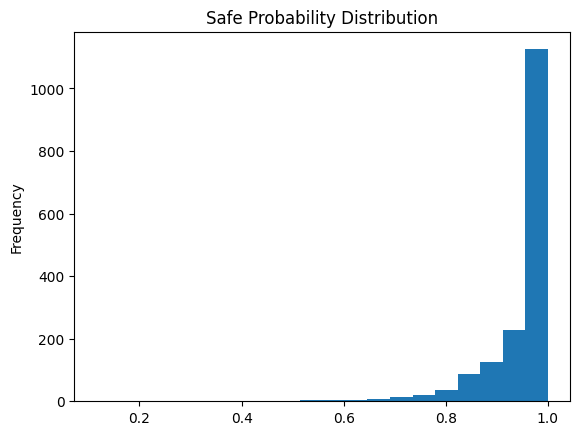

In [37]:
final_probs['safe_probability'].plot(kind='hist', bins=20, title='Safe Probability Distribution')